# Optimizing QAOA by Bayesian Optimization (BO)

## Overview

In this tutorial, we show how to use Bayesian optimization to optimize QAOA. For the introduction of QAOA, please refer to the [previous tutorial](qaoa.ipynb). Bayesian optimization in this tutorial is based on $\text{ODBO}$, please refer to [Cheng, Yang, Hsieh, Liao and Zhang](https://doi.org/10.48550/arXiv.2205.09548) for details and this [repository](https://github.com/tencent-quantum-lab/ODBO) for source code and [installation](https://github.com/tencent-quantum-lab/ODBO#installation). In this tutorial, the updated modules of BO, TuRBO and DARBO are packaged.

## Setup

In [1]:
import tensorcircuit as tc
from jax import numpy as jnp
import optax
import torch
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import cotengra as ctg
from typing import Union
import time
import odbo
from IPython.display import clear_output

K = tc.set_backend("jax")
tc.set_dtype("complex128")
dtype = torch.float64

# cotengra package to speed up the calculation
opt_ctg = ctg.ReusableHyperOptimizer(
    methods = ["greedy", "kahypar"],
    parallel = True,
    minimize = "combo",
    max_time = 20,
    max_repeats = 128,
    progbar = True
)

tc.set_contractor("custom", optimizer=opt_ctg, preprocessing=True)

nlayers = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
acqfn = "ucb"

2023-07-14 16:25:57.015620: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## MAX-CUT Hamiltonian

### Define the Graph

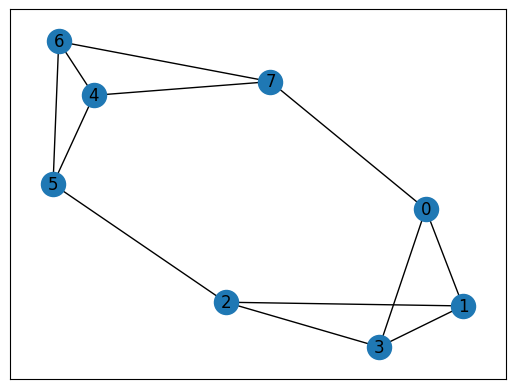

In [2]:
# a graph instance
graph_dict = {
    0: {1: {"weight": 1.0}, 7: {"weight": 1.0}, 3: {"weight": 1.0}},
    1: {0: {"weight": 1.0}, 2: {"weight": 1.0}, 3: {"weight": 1.0}},
    2: {1: {"weight": 1.0}, 3: {"weight": 1.0}, 5: {"weight": 1.0}},
    3: {1: {"weight": 1.0}, 2: {"weight": 1.0}, 0: {"weight": 1.0}},
    4: {7: {"weight": 1.0}, 6: {"weight": 1.0}, 5: {"weight": 1.0}},
    5: {6: {"weight": 1.0}, 4: {"weight": 1.0}, 2: {"weight": 1.0}},
    6: {7: {"weight": 1.0}, 4: {"weight": 1.0}, 5: {"weight": 1.0}},
    7: {4: {"weight": 1.0}, 6: {"weight": 1.0}, 0: {"weight": 1.0}},
}

graph = nx.to_networkx_graph(graph_dict)
pos = nx.spring_layout(graph)
nx.draw_networkx(graph, with_labels=True, pos=pos)
ax = plt.gca()
ax.set_facecolor('w')

### Brutal Force Result

bit string: ['01010101', '10101010'] 
max cut: 10.0


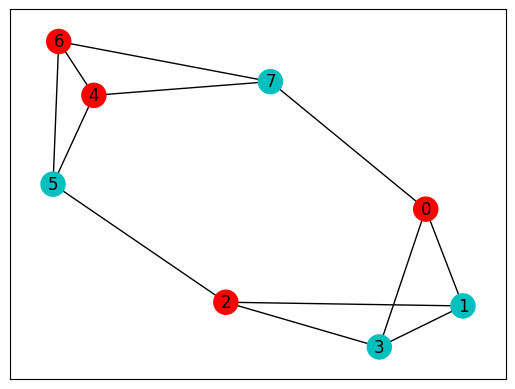

In [3]:
def classical_solver(graph):
    num_nodes = len(graph)
    max_cut = [0]
    best_case = [0]  # "01" series with max cut
    for i in range(2 ** num_nodes):
        case = f"{bin(i)[2:]:0>{num_nodes}}"
        cat1, cat2 = [], []
        for j in range(num_nodes):
            if str(case)[j] == "0":
                cat1.append(j)
            else:
                cat2.append(j)

        # calculate the cost function
        cost = 0
        for node1 in cat1:
            for node2 in cat2:
                if graph[node1].get(node2):
                    cost += graph[node1][node2]["weight"]
        cost = round(cost, 4)  # elimate minor error
        if max_cut[-1] <= cost:
            max_cut.append(cost)
            best_case.append(case)

    # optimal cases maybe more than 1, but they are all at the end
    index = max_cut.index(max_cut[-1])

    return max_cut[-1], best_case[index:]

max_cut, best_case = classical_solver(graph_dict)
print("bit string:", best_case, "\nmax cut:", max_cut)

colors = ["r" if best_case[0][i] == "0" else "c" for i in graph.nodes]
weighted_graph = nx.to_networkx_graph(graph_dict)
nx.draw_networkx(weighted_graph, with_labels=True, node_color=colors, pos=pos)
ax = plt.gca()
ax.set_facecolor("w")

## QAOA Ansatz

In [4]:
def QAOAansatz(params, each=1, return_circuit=False):
    n = graph.number_of_nodes()  # the number of nodes

    # PQC loop
    def pqc_loop(s_, params_):
        c_ = tc.Circuit(n, inputs=s_)
        for j in range(each):
            # driving layer
            for a, b in graph.edges:
                c_.RZZ(a, b, theta=graph[a][b]['weight'] * params_[2 * j])
            # mixing layer
            for i in range(n):
                c_.RX(i, theta=params_[2 * j + 1])
        s_ = c_.state()
        return s_

    c0 = tc.Circuit(n)
    for i in range(n):
        c0.H(i)
    s0 = c0.state()
    s = K.scan(pqc_loop, K.reshape(params, [nlayers // each, 2 * each]), s0)
    c = tc.Circuit(n, inputs=s)

    # whether to return the circuit
    if return_circuit is True:
        return c

    # calculate the loss function
    loss = 0.
    for a, b in graph.edges:
        loss += c.expectation_ps(z=[a, b]) * graph[a][b]['weight']

    return K.real(loss)

In [5]:
QAOA_vag = K.jit(tc.backend.value_and_grad(QAOAansatz, argnums=0), static_argnums=(1, 2))
QAOA_nograd = K.jit(QAOAansatz, static_argnums=(1, 2))

def eval_objective(x):
    """This is a helper function we use to unnormalize and evalaute a point"""
    return -torch.from_numpy(np.asarray(QAOA_nograd(jnp.asarray(x.ravel()))))

## Adam Optimizer

In [6]:
opt = K.optimizer(optax.adam(1e-2))

## BO Optimizer

In [7]:
class BO_optimizer:
    def __init__(self, eval_func, batch_size: int = 1, device='cpu'):
        self.eval_func = eval_func
        self.device = device
        self.batch_size = batch_size

    def computeY(self, X):
        return torch.tensor([self.eval_func(x) for x in X], dtype=X.dtype, device=self.device).unsqueeze(-1)

    def update(self, X, Y=None, acqfn: str = "ucb", normalize: bool = False, verbose: bool = False):
        if Y is None:
            Y = self.computeY(X)
        X_next = odbo.run_exp.bo_design(X=X, Y=Y, batch_size=self.batch_size, acqfn=acqfn, normalize=normalize, verbose=verbose)[0].reshape(self.batch_size, X.shape[-1])
        Y_next = self.computeY(X_next)
        # Update training set
        X = torch.cat((X, X_next), dim=0)
        Y = torch.cat((Y, Y_next), dim=0)
        best_idx = torch.argmax(Y, dim=0)

        return X, Y, Y_next.mean().item(), X[best_idx], Y[best_idx].item()

In [8]:
batch_size = 1

bo_opt = BO_optimizer(eval_objective, batch_size, device)

## TuRBO Optimizer

In [9]:
class TuRBO_optimizer(BO_optimizer):
    def __init__(self, eval_func, num_params, tr_length, failure_tolerance, device="cpu"):
        super(TuRBO_optimizer, self).__init__(eval_func, device=device)
        self.batch_size = 1   # There is bug in odbo.run_exp.turbo_design, batch_size can only be 1
        self.tr_length = tr_length
        self.state = odbo.turbo.TurboState(dim=num_params, batch_size=batch_size, length=tr_length, n_trust_regions=len(tr_length), failure_tolerance=failure_tolerance)

    def inverse_transform(self, X):
        '''
            Note TuRBO is working on only [0,1] parameter range
            We need to transform parameters from [0,1] to [-pi,pi] before using eval_func
        '''
        return X * 2 * np.pi - np.pi

    def transform(self, X):
        '''
            Note TuRBO is working on only [0,1] parameter range
            We need to transform parameters from [-pi,pi] to [0,1] before using odbo.run_exp.turbo_design
        '''
        return X / 2 / np.pi + 0.5

    def computeY(self, X, transformed_input: bool = True):
        if transformed_input:
            X = self.inverse_transform(X)
        return torch.tensor([self.eval_func(x) for x in X], dtype=X.dtype, device=self.device).unsqueeze(-1)

    def get_next(self, X, Y, acqfn, normalize, verbose):
        X_next = odbo.run_exp.turbo_design(state=self.state, X=X, Y=Y, n_trust_regions=len(self.tr_length), batch_size=self.batch_size, acqfn=acqfn, normalize=normalize, verbose=verbose)[0].reshape(len(self.tr_length) * self.batch_size, X.shape[-1])
        Y_next = self.computeY(X_next)
        return X_next, Y_next

    def update_state(self, Y_next):
        self.state = odbo.turbo.update_state(state=self.state, Y_next=Y_next.reshape(len(self.tr_length), self.batch_size, 1))

    def preprocess(self, X, Y, transformed_input):
        if not transformed_input:
            X = self.transform(X)
        if Y is None:
            Y = self.computeY(X)
            self.state.best_value = max(self.state.best_value, Y.max())
        return X, Y

    def postprocess(self, X, Y, X_next, Y_next, transformed_output):
        X = torch.cat((X, X_next), dim=0)
        Y = torch.cat((Y, Y_next), dim=0)
        if not transformed_output:
            X = self.inverse_transform(X)
        best_idx = torch.argmax(Y, dim=0)
        return X, Y, X[best_idx]

    def update(self, X, Y=None, acqfn: str = "ucb", normalize: bool = False, verbose: bool = False, transformed_input: bool = False, transformed_output: bool = False):
        X, Y = self.preprocess(X, Y, transformed_input)

        X_next, Y_next = self.get_next(X, Y, acqfn, normalize, verbose)

        self.update_state(Y_next)

        X, Y, best_X = self.postprocess(X, Y, X_next, Y_next, transformed_output)

        return X, Y, Y_next.mean().item(), best_X, self.state.best_value

In [10]:
failure_tolerance = 10
tr_length= [1.6]

turbo_opt = TuRBO_optimizer(eval_objective, 2 * nlayers, tr_length, failure_tolerance, device)

## DARBO Optimizer

Please refer to [Cheng, Chen, Zhang and Zhang](https://doi.org/10.48550/arXiv.2303.14877) for details.

In [11]:
class DARBO_optimizer(TuRBO_optimizer):
    def __init__(self, eval_func, num_params, tr_length, failure_tolerance, mode: Union[bool, str] = True, device="cpu"):
        super(DARBO_optimizer, self).__init__(eval_func, num_params, tr_length, failure_tolerance, device)
        self.switch_counter = 0
        if mode ==True or mode == 'large':
            self.mode = True
        else:
            self.mode = False

    def get_mode(self):
        return 'large' if self.mode else 'small'

    def inverse_transform(self, X):
        '''
            Note TuRBO is working on only [0,1] parameter range
            We need to transform parameters from [0, 1] to [-pi, pi] or [-pi / 2, pi / 2] before using eval_func
        '''
        if self.mode:   # [0, 1] to [-pi, pi]
            return X * 2 * np.pi - np.pi
        else:           # [0, 1] to [-pi / 2, pi / 2]
            return X * np.pi - np.pi / 2

    def transform(self, X):
        '''
            Note TuRBO is working on only [0,1] parameter range
            We need to transform parameters from [-pi,pi] or [-pi / 2, pi / 2] to [0,1] before using odbo.run_exp.turbo_design
        '''
        if self.mode:   # [-pi, pi] to [0, 1]
            return X / 2 / np.pi + 0.5
        else:           # [-pi / 2, pi / 2] to [0, 1]
            return X / np.pi + 0.5

    def computeY(self, X, transformed_input: bool = True):
        if transformed_input:
            X = self.inverse_transform(X)
        return torch.tensor([self.eval_func(x) for x in X], dtype=X.dtype, device=self.device).unsqueeze(-1)

    def update(self, X, Y=None, acqfn: str = "ucb", normalize: bool = False, verbose: bool = False, transformed_input: bool = False, transformed_output: bool = False):
        X, Y = self.preprocess(X, Y, transformed_input)

        # check if we need to switch the searching parameter range.
        if self.switch_counter >= 4:
            if self.mode:
                X *= 2
                self.mode = False  # small
            else:
                X /= 2
                self.mode = True   # large
            self.switch_counter = 0

        X_next, Y_next = self.get_next(X, Y, acqfn, normalize, verbose)

        if Y_next.max() < Y.max():
            self.switch_counter += 1

        self.update_state(Y_next)

        X, Y, best_X = self.postprocess(X, Y, X_next, Y_next, transformed_output)

        return X, Y , Y_next.mean().item(), best_X, self.state.best_value

In [12]:
mode = 'small'

darbo_opt = DARBO_optimizer(eval_objective, 2 * nlayers, tr_length, failure_tolerance, mode, device)
print(f'initial mode: {darbo_opt.get_mode()}')

initial mode: small


## Optimization

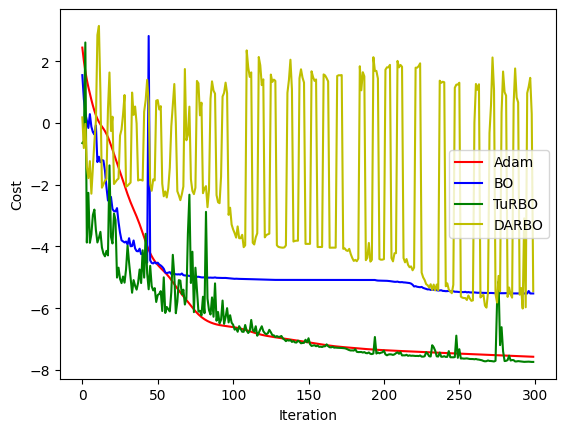

Epoch 299 min loss: -7.575720919791415	-5.524467468261719	-7.743190336435761	-6.011992874299757
Epoch 299 time: 15.6287100315094	Total time: 2132.036656141281


In [13]:
# initial parameters
params = K.implicit_randu(shape=(2 * nlayers,))
initial_X = torch.from_numpy(np.asarray(params)).type(dtype)

# First point by BO is actually just a random selection, to have a better search, we pick the most distant point
X_new = []
for i in initial_X:
    if i <= 0.5:
        X_new.append(i + 0.5)
    else:
        X_new.append(i - 0.5)
X_new = torch.tensor(X_new)

X_bo = torch.stack((initial_X, X_new), dim=0)
Y_bo = None
X_turbo = X_bo.clone()
Y_turbo = None
X_darbo = X_bo.clone()
Y_darbo = None

losses, losses_bo, losses_turbo, losses_darbo = [], [], [], []
t0 = ts = time.time()

for i in range(300):
    loss, grads = QAOA_vag(params)
    params = opt.update(grads, params)  # gradient descent
    losses.append(loss)

    X_bo, Y_bo, loss, X_bo_best, bo_max = bo_opt.update(X_bo, Y_bo, acqfn)
    losses_bo.append(-loss)

    X_turbo, Y_turbo, loss, X_turbo_best, turbo_max = turbo_opt.update(X_turbo, Y_turbo, acqfn, transformed_input=False if i == 0 else True, transformed_output=True)
    losses_turbo.append(-loss)

    X_darbo, Y_darbo, loss, X_darbo_best, darbo_max = darbo_opt.update(X_darbo, Y_darbo, acqfn, transformed_input=False if i == 0 else True, transformed_output=True)
    losses_darbo.append(-loss)

    # visualise the progress
    clear_output(wait=True)
    plt.figure()
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.plot(range(i + 1), losses, c='r', label='Adam')
    plt.plot(range(i + 1), losses_bo, c='b', label='BO')
    plt.plot(range(i + 1), losses_turbo, c='g', label='TuRBO')
    plt.plot(range(i + 1), losses_darbo, c='y', label='DARBO')
    plt.legend()
    plt.show()

    print(f'Epoch {i} min loss: {min(losses)}\t{-bo_max}\t{-turbo_max}\t{-darbo_max}')

    te = time.time()
    print(f'Epoch {i} time: {te - ts}\tTotal time: {te - t0}')
    ts = te

## Results

After inputting the optimized parameters back to the ansatz circuit, we can perform the projective measurement on the output quantum state to get the solution. Here we directly use the bit string with the maximum probability as the solution since we know all information of the probability distribution of the output quantum state, but which is not feasible in the experiment.

In [14]:
params_bo = jnp.asarray(X_bo_best.ravel())
params_turbo = jnp.asarray(turbo_opt.inverse_transform(X_turbo_best).ravel())
params_darbo = jnp.asarray(darbo_opt.inverse_transform(X_darbo_best).ravel())

# find the states with max probabilities
def find_max(params):
    loss = QAOA_nograd(params)
    c = QAOAansatz(params, return_circuit=True)
    probs = K.numpy(c.probability())
    max_prob = max(probs)
    index = np.where(probs == max_prob)[0]
    states = []
    for i in index:
        states.append(f'{bin(i)[2:]:0>{graph.number_of_nodes()}}')
    return loss, max_prob, states

loss, prob, states = find_max(params)
loss_bo, prob_bo, states_bo = find_max(params_bo)
loss_turbo, prob_turbo, states_turbo = find_max(params_turbo)
loss_darbo, prob_darbo, states_darbo = find_max(params_darbo)
print(f'Adam\nloss: {loss}\tprob: {prob}\tbit strings: {states}\n')
print(f'BO\nloss: {loss_bo}\tprob: {prob_bo}\tbit strings: {states_bo}\n')
print(f'TuRBO\nloss: {loss_turbo}\tprob: {prob_turbo}\tbit strings: {states_turbo}\n')
print(f'DARBO\nloss: {loss_darbo}\tprob: {prob_darbo}\tbit strings: {states_darbo}')

Adam
loss: -7.577690877449574	prob: 0.432590481525006	bit strings: ['01010101', '10101010']

BO
loss: -5.52446757529149	prob: 0.17464402602528795	bit strings: ['10101010']

TuRBO
loss: -7.743190336435761	prob: 0.4689543236081881	bit strings: ['10101010']

DARBO
loss: -6.011992874299757	prob: 0.23617910579498852	bit strings: ['01010101']


In [15]:
tc.about()

OS info: Linux-5.4.119-1-tlinux4-0010.2-x86_64-with-glibc2.28
Python version: 3.10.11
Numpy version: 1.23.5
Scipy version: 1.11.0
Pandas version: 2.0.2
TensorNetwork version: 0.4.6
Cotengra version: 0.2.1.dev15+g120379e
TensorFlow version: 2.12.0
TensorFlow GPU: []
TensorFlow CUDA infos: {'cpu_compiler': '/dt9/usr/bin/gcc', 'cuda_compute_capabilities': ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80'], 'cuda_version': '11.8', 'cudnn_version': '8', 'is_cuda_build': True, 'is_rocm_build': False, 'is_tensorrt_build': True}
Jax version: 0.4.13
Jax installation doesn't support GPU
JaxLib version: 0.4.13
PyTorch version: 2.0.1
PyTorch GPU support: False
PyTorch GPUs: []
Cupy is not installed
Qiskit version: 0.24.1
Cirq version: 1.1.0
TensorCircuit version 0.10.0
